# Análisis de Series Temporales

## 1 Objetivos y Perspectiva General

En el presente artículo analizaremos una conjunto de modelos de series temporales, los cuales se basan en el estudio de datos secuenciales registrados en intervalos regulares de tiempo, con el objetivo de identificar patrones, tendencias, estacionalidad y realizar predicciones futuras.

En nuestro análisis práctica sobre series temporales usaremos el dataset de [manchas solares](https://www.kaggle.com/datasets/robervalt/sunspots/data), que consta de de la media de las manchas solares por mes desde 1749 hasta 2018. Con este, pretendemos poder predecir esta media a través de modelos de prediccón de series temporales.

<img src="https://www.spaceweatherlive.com/images/help/zonnevlekken_magnetisch/beta-gamma-delta_1.jpg" alt="Drawing" style="width: 600px;"/>

¡Comenzamos!

## 2 Importación de librerías y paquetes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore") 

## 3 Lectura y Visualización de datos

In [2]:
df = pd.read_csv("datasets\sunspots\Sunspots.csv", index_col=0)
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               3265 non-null   object 
 1   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), object(1)
memory usage: 76.5+ KB


Los datos muestran el número medio mensual de manchas solares desde enero de 1749, lo que constituye una serie temporal que abarca más de 270 años. Antes de realizar un análisis detallado, es esencial inspeccionar las tendencias, patrones estacionales y posibles valores atípicos mediante.

In [4]:
df.describe()

,Monthly Mean Total Sunspot Number
count,3265.000000
mean,81.778775
std,67.889277
min,0.000000
25%,23.900000
50%,67.200000
75%,122.500000
max,398.200000


Respecto al análisis estadístico descriptivo del dataset, se observa que las manchas solares muestra una media de 81.78 manchas mensuales, con una alta variabilidad reflejada en una desviación estándar de 67.89. El rango va de 0 a 398.2, indicando la presencia de periodos con actividad solar muy baja y otros con picos máximos significativos.

Por último, procedemos a convertir la columna Date a un formato de fecha y hora (datetime) en pandas antes de proceder con la exploración de datos detallada, lo cual nos permitirá realizar análisis temporales como filtrado, agrupación por fechas, y visualización de tendencias.

In [5]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

## 2 Exploración de los datos 

Para explorar lo datos de forma detallada generaremos un gráfico de líneas que muestra la evolución del número medio mensual de manchas solares a lo largo del tiempo. Esto permite visualizar las fluctuaciones y tendencias en la actividad solar durante los últimos 270 años, facilitando el análisis de patrones y ciclos temporales.

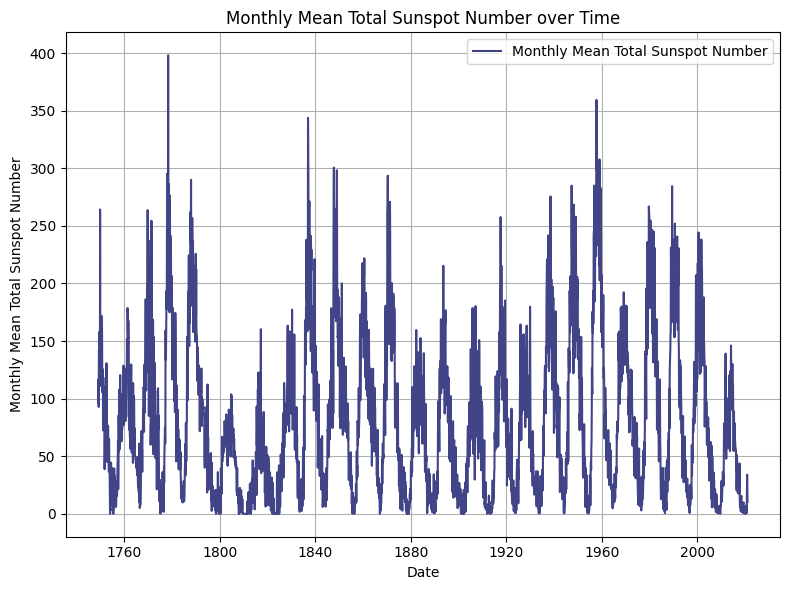

In [6]:
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 3))

plt.figure(figsize=(8,6))
plt.plot(df['Date'], df['Monthly Mean Total Sunspot Number'], label='Monthly Mean Total Sunspot Number', color=cmap(0.2))
plt.xlabel('Date')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.title('Monthly Mean Total Sunspot Number over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

En el gráfico de líneas represntado anteriormente se observa que hay cierto patrón temporal en los datos. Estos ciclos son conocidos como ciclos solares y suelen durar alrededor de 11 años. Durante cada ciclo, la actividad solar aumenta hasta un máximo y luego disminuye hasta un mínimo. En tu gráfico, estos ciclos son visibles como los picos y valles repetitivos.

Podemos ver también, que aun que siguien cierto patrón relativamente regular, la intensidad si que es variable, dando picos de máxima diferentes entre ellos.

Por último, procedemos con el entrenamiento de los datos para posteriormente realizar comparativas entre diferentes modelos de series temporales.

In [7]:
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

## 3 Comparación Modelos de Clasificación

Para la comparativa de modelos, usaremos el _Simple Moving Average_ (SMA), _Holt-Winters_ (Exponential Smoothing) y _Autoregressive Integrated Moving Average_ (ARIMA). 

Proporcionamos una breve descripción de cada modelo para su mejor comprensión por parte de los lectores:

* Simple Moving Average (SMA): Calcula un promedio móvil simple usando una ventana de tamaño especificado (por defecto 12).
* Holt-Winters Exponential Smoothing: Aplica suavizamiento exponencial con componentes estacionales y de tendencia (modelo Holt-Winters).
* Modelo ARIMA (AutoRegressive Integrated Moving Average): Combina componentes autoregresivos, de diferenciación y de media móvil para capturar patrones y hacer predicciones

Para conseguir un resultado dinámico y robusto, declararemos los parámetros específicos de cada modelo en una función. Posteriormente, le enviaremos a cada función los datos de entrenamiento y testeo para preparar los modelos y obtener los resultados finales.

In [8]:
# 1. Promedio Móvil Simple (SMA)
def simple_moving_average(train, test, window=12):
    rolling_mean = train['Monthly Mean Total Sunspot Number'].rolling(window=window).mean()
    pred = rolling_mean[-len(test):]  
    return pred

# 2. Holt-Winters (Exponential Smoothing)
def holt_winters(train, test):
    model = ExponentialSmoothing(train['Monthly Mean Total Sunspot Number'], trend=None, seasonal='add', seasonal_periods=220).fit()
    pred = model.forecast(len(test))  
    return pred

# 3. ARIMA
def arima_model(train, test, order=(4,0,1),seasonal_order=(2, 0, 2, 11)):
    model = ARIMA(train['Monthly Mean Total Sunspot Number'], order=order, seasonal_order=seasonal_order).fit()
    pred = model.forecast(steps=len(test)) 
    return pred


A continuación, se definen los diferentes modelos de series temporales y se proporcionan de entrenamiento y testeo para posteriormente evaluar los resultados obtenidos.

In [9]:
sma_pred = simple_moving_average(train_data, test_data)

hw_pred = holt_winters(train_data, test_data)

arima_pred = arima_model(train_data, test_data)

## 4 Evaluación de Modelos

En este último apartado, se comparan las predicciones generadas por los modelos SMA, Holt-Winters y ARIMA frente a los datos reales de manchas solares. Los gráficos permiten evaluar visualmente la precisión de cada modelo, mientras que el error cuadrático medio (MSE) proporciona una medida cuantitativa de su desempeño.

Simple Moving Average - MSE: 8431.5951
Holt-Winters - MSE: 4742.4447
ARIMA - MSE: 3644.9214


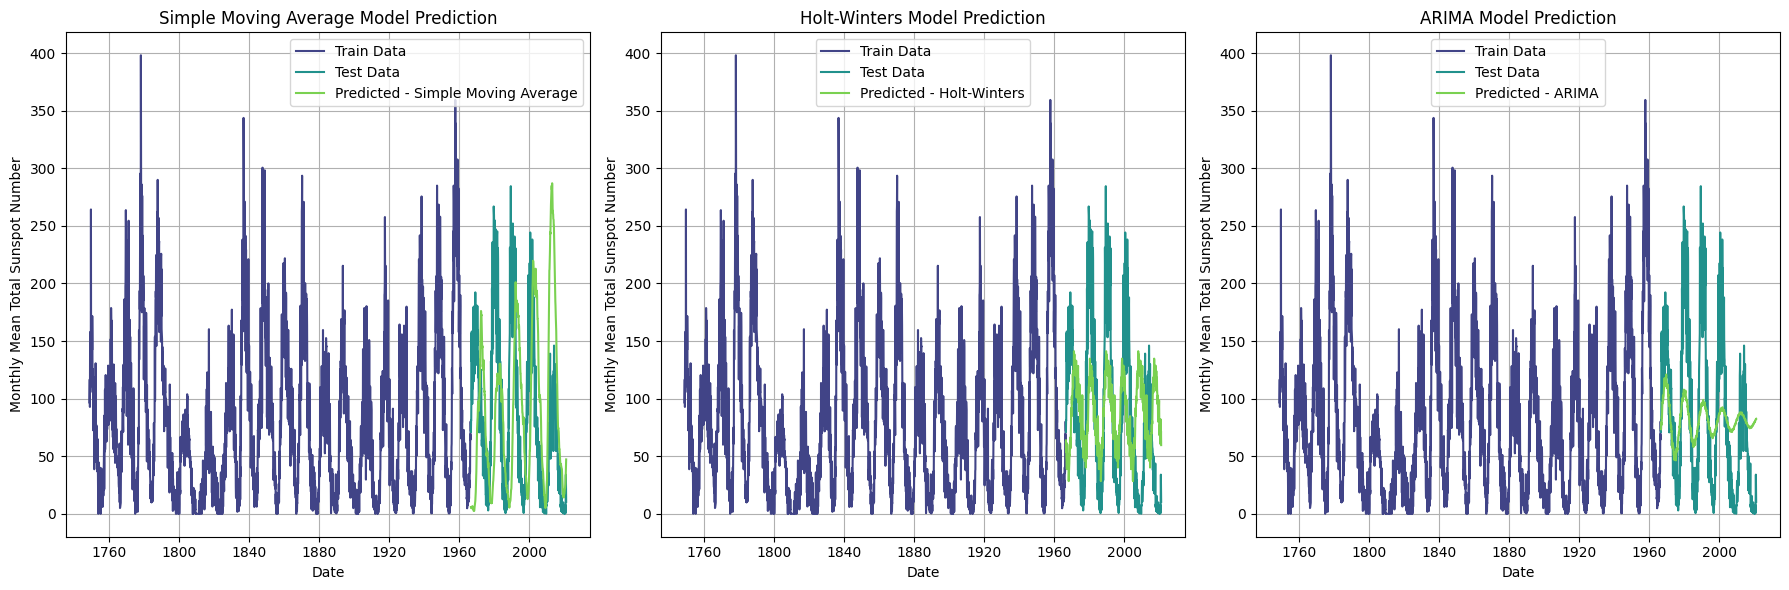

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

models = ['Simple Moving Average', 'Holt-Winters', 'ARIMA']
preds = [sma_pred, hw_pred, arima_pred]

for i, (model, pred) in enumerate(zip(models, preds)):
    pred = np.array(pred)
    test_values = test_data['Monthly Mean Total Sunspot Number'].values

    pred = pred[~np.isnan(pred)]
    test_values = test_values[-len(pred):] 
    mse = mean_squared_error(test_values, pred)
    print(f'{model} - MSE: {mse:.4f}')
    
    axs[i].plot(train_data['Date'], train_data['Monthly Mean Total Sunspot Number'], label='Train Data', color=cmap(0.2))
    axs[i].plot(test_data['Date'], test_data['Monthly Mean Total Sunspot Number'], label='Test Data', color=cmap(0.5))
    axs[i].plot(test_data['Date'][-len(pred):], pred, label=f'Predicted - {model}', color=cmap(0.8))
    
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Monthly Mean Total Sunspot Number')
    axs[i].set_title(f'{model} Model Prediction')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


Tras la observación de los gráficos anteriores, podemos extraer las siguientes conclusiones:

* El modelo SMA parece suavizar las oscilaciones, pero no captura bien la estructura cíclica de las manchas solares. Aunque es un método simple y da una idea general de la tendencia, la predicción SMA no es tan precisa para este tipo de serie temporal cíclica, ya que no captura ni los picos ni los valles con precisión. Esto se ve reflejado en el MSE, el cual es el más alto de los tres modelos.

* El modelo _Holt-Winters_ hace un mejor trabajo que el SMA en capturar la naturaleza cíclica de los datos. Se observa que las predicciones siguen un patrón de subidas y bajadas más similar a los ciclos observados en los datos de prueba. Pero sin embargo, le cuesta acercarse más a los valles y picos que se ha ido mostrando durante el entrenamiento y parece estar un poco desfasada.

* El modelo ARIMA parece hacer una predicción más constante, pero no captura bien los picos ni los valles, de la misma forma que le pasa a _Holt-Winters_. Esto sugiere que el modelo ARIMA está más enfocado en predecir la media a largo plazo de la serie y no es tan bueno en captar las fluctuaciones cíclicas.

Por lo tanto, con estos resultados se extrae la importancia de estudiar bien los datos antes de decidir que modelos usar, ya que dependiendo de el tipo de estacionalidad, tendencias o ciclos, unos se adaptan mejor que otros.

## ¡Muchas gracias por leer!